In [ ]:
'''
In coding we believe
University of Illinois @ Urbana - Champaign
Summer 2023
  ____        _              ____            _      _
 / ___|  __ _| | __ _ _ __  | __ )  __ _ ___(_)_ __(_)
 \___ \ / _` | |/ _` | '__| |  _ \ / _` / __| | '__| |
  ___) | (_| | | (_| | |    | |_) | (_| \__ \ | |  | |
 |____/ \__,_|_|\__,_|_|    |____/ \__,_|___/_|_|  |_|

'''

In [ ]:
from numpy import *
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.special import *
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from matplotlib import patches
import warnings
import math

In [ ]:
my_inf=1e6
def my_log(m):
    res = log(m, out=np.zeros_like(m), where=(m>0))
    return res
def return_arc_length(points, center, r): # so far calculating euclidean distance!!!!!!!!!!!!!!
    x1, y1 = points[0]
    x2, y2 = points[1]
    c_x, c_y = center
    if x1==x2 and y1==y2:
        return 0.0
    # Calculate the distance between the center of the circle and the line segment
    dist = np.abs((y2 - y1) * c_x - (x2 - x1) * c_y + x2 * y1 - x1 * y2) / np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    # Check if the distance is less than or equal to the radius
    if dist < r:
        d = 2 * np.sqrt(r ** 2 - dist ** 2)
        l = 2*r*math.atan(d/math.sqrt(4*r**2-d**2+1e-8))
        return l-d
    else:
        return 0.0
def add_block_dist(center,r):
  return lambda u,v:return_arc_length([u,v],center,r)

class uav_flpo:
    def __init__(self,drones,stations,blocks=None,
                 fcr=25,distance='euclidean') -> None:
        super().__init__()
        self.drones=drones
        self.stations=stations
        self.blocks=blocks
        self.N_drones= len(drones)
        self.N_stations=len(stations)
        self.stage_horizon=self.N_stations+1
        self.gamma_k_length=self.N_stations+1
        self.fcr=fcr
        self.distance=distance
        self.get_distances()
        self.S=np.ones((self.N_stations+1,self.N_drones))*my_inf # the schedule matrix
        # self.S=np.random.rand(self.N_stations+1,self.N_drones) # the schedule matrix
        return

    def get_distances(self,): #params is like stations
        d_F=cdist(self.stations,self.stations,self.distance)
        if not self.blocks==None:
            for block in self.blocks:
                d_F+=cdist(self.stations,self.stations,metric=add_block_dist(block[0],block[1]))
        d_F+=diag([my_inf]*self.N_stations)
        d_delta_to_f=array([my_inf]*self.N_stations).reshape(1,-1)
        d_df=np.concatenate((d_F,d_delta_to_f),axis=0)
        D_ss=[0]*self.N_drones
        m=0.0
        for drone_id,drone in enumerate(self.drones):
            stage=concatenate((self.stations,array(self.drones[drone_id][1]).reshape(1,-1)),axis=0)
            D_s=[0]*2
            stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
            D_s[0]=cdist(stage_0,stage,self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    D_s[0]+=cdist(stage_0,stage,metric=add_block_dist(block[0],block[1]))

            m1=np.max(D_s[0])/self.drones[drone_id][4]

            D_s[0]+=0.5*my_inf*tanh(D_s[0]-self.drones[drone_id][2]*self.fcr)+0.5*my_inf

            D_s[0]=D_s[0]/self.drones[drone_id][4]

            d_f_to_delta=cdist(self.stations,array(self.drones[drone_id][1]).reshape(1,-1),self.distance)
            if not self.blocks==None:
                for block in self.blocks:
                    d_f_to_delta+=cdist(self.stations,array(self.drones[drone_id][1]).reshape(1,-1),metric=add_block_dist(block[0],block[1]))
            d_last=np.concatenate((d_f_to_delta,array([0]).reshape(1,-1)),axis=0)
            d=np.concatenate((d_df,d_last),axis=1)
            m2=np.max((d-diag(d))[:-1,:])/self.drones[drone_id][4]
            d=d+(0.5*my_inf*tanh(d-self.fcr)+0.5*my_inf)
            D_s[1]=d/self.drones[drone_id][4]
            # d_l=[my_inf]*(self.gamma_k_length-1)
            # d_l.append(0.0)
            # D_s[-1]=(array(d_l).reshape(-1,1))/self.drones[drone_id][4]
            m=np.max([m,m1,m2])
            D_ss[drone_id]=D_s
        self.T_ss=D_ss
        self.m=m
        print('Distances calculated...')
        return
    def return_stagewise_cost(self,params):
        D_ss=[0]*self.N_drones
        for drone_id,drone in enumerate(self.drones):
            D_s=[0]*(self.stage_horizon+1)
            stage_0=array(self.drones[drone_id][3]).reshape(1,-1)
            stage=params[:,drone_id].reshape(-1,1)
            D_s[0]=cdist(stage_0,stage,self.distance)
            D_s[0]+=0.5*my_inf*tanh(self.T_ss[drone_id][0]-D_s[0])+0.5*my_inf
            d_F=cdist(stage,stage,self.distance)
            d_F+=0.5*my_inf*tanh(self.T_ss[drone_id][1]-d_F)+0.5*my_inf
            d_F[-1,-1]=0.0
            D_s[1:self.stage_horizon] = [d_F] * (self.stage_horizon - 1)
            d_l=[my_inf]*(self.gamma_k_length-1)
            d_l.append(0.0)
            D_s[-1]=array(d_l).reshape(-1,1)
            D_ss[drone_id]=D_s
        self.D_ss=D_ss
        return

    def calc_associations(self,beta):
        p=[]
        self.return_stagewise_cost(self.params.reshape(self.S.shape))
        D_ss=self.D_ss
        for D_s in D_ss:
            K=len(D_s)
            D=D_s[::-1]
            out_D=[0]*(K+1)
            out_D[0]=array([0.0]).reshape(-1,1)
            out_p=[0]*(K+1)
            out_p[0]=array([1.0]).reshape(-1,1)
            out=[0]*(K+1)
            out[0]=array([1.0]).reshape(-1,1)
            for i in range(1,K+1):
                out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
                m=out_D[i].min(axis=1,keepdims=True)
                exp_D=exp(multiply(-beta,out_D[i]-m))
                out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
                out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
                out_D[i]=m
            p.append(out_p[::-1][:-1])
        self.P_ss=p
        return
    def free_energy(self,D_s,P_s,beta):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''

        K=len(D_s)
        D=D_s[::-1]
        P=P_s[::-1]
        out_P=[0]*(K+1)
        out_C=[0]*(K+1)
        out_H=[0]*(K+1)
        out_P[0]=array([1.0]).reshape(-1,1)
        out_C[0]=array([0.0]).reshape(-1,1)
        out_H[0]=array([0.0]).reshape(-1,1)
        for i in range(1,K+1):
          # assigning P of each node for calculating C in the next i
          out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
          out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
        # D-1/beta*H
        return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
    def free_energy_Gibbs(self,D_s,beta):
        K=len(D_s)
        D=D_s[::-1]
        out_D=[0]*(K+1)
        out_D[0]=array([0.0]).reshape(-1,1)
        out=[0]*(K+1)
        out[0]=array([1.0]).reshape(-1,1)
        for i in range(1,K+1):
            out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
            m=out_D[i].min(axis=1,keepdims=True)
            exp_D=exp(multiply(-beta,D[i-1]))
            out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
            out_D[i]=m
        if isclose(out[-1],0.0).all():
            return m.sum()
        else:
            return (-1/beta*log(out[-1]).sum())

    def objective(self,params,beta):
        self.return_stagewise_cost(params.reshape(self.S.shape))
        cost=0
        for i in range(len(self.D_ss)):
            cost+=self.free_energy_Gibbs(self.D_ss[i],beta)
        return cost

    def optimize_D(self,init_guess,beta,method):
        lb=[0.0]*len(init_guess)
        ub=[self.m*(self.N_stations+1)]*len(init_guess)
        # ub=[my_inf]*len(init_guess)
        bounds = [(l, u) for l, u in zip(lb, ub)]
        result = minimize(self.objective, init_guess,args=(beta,),bounds=bounds,method=method)
        self.params = result.x
        self.cost_fun=result.fun
    def optimize_ga(self,init_guess,beta):
        bounds=np.array([[0.0,self.m*(self.N_stations+1)]]*len(init_guess))
        model=ga(function=lambda params:self.objective(params,beta),dimension=len(init_guess),
                 variable_type='real',variable_boundaries=bounds)
        model.run()
        print(model.ouput_dict)
        self.params = result.x
        self.cost_fun=result.fun
    def calc_routs(self):
        O=[]
        for i in range(self.N_drones):
          m=0
          o=[]
          for p in self.P_ss[i]:
              m=argmax(p[m,:])
              o.append(m)
          o.pop()
          O.append(o)
        self.routs=O

    def train(self,beta_init=1e-6,beta_f=100,alpha=1.5,purturb=0.1,method='nelder-mead',verbos=0):
        self.Y_s=[]
        self.Betas=[]
        self.params=ndarray.flatten(self.S)
        beta=beta_init
        # self.return_stagewise_cost(self.params.reshape(self.S.shape))
        old_cost=my_inf
        while beta <= beta_f:
            count=0
            self.params=self.params+random.normal(0, purturb, self.params.shape)
            self.optimize_D(self.params,beta,method=method) #based on P_ss
            count+=1
            if verbos:
              print(f'Beta: {beta:.4e}  F.E.: {self.cost_fun:0.5e}')
            if abs(self.cost_fun-old_cost) <= 1e-3:
                print("--Optimization Terminated--")
                break
            old_cost=self.cost_fun
            beta=beta*alpha
            self.Y_s.append(self.params.reshape(self.S.shape))
            self.Betas.append(beta)
        self.calc_associations(beta) #based on D_ss
        self.calc_routs()

    def print_routs(self):
        print("")
        for i,o in enumerate(self.routs):
          t=self.drones[i][3]
          print(f'\nDrone{i+1}({t:.2f}) --->', end='')
          for index,j in enumerate(o):
            if j<self.N_stations:
              if index==0:
                t=t+abs(t-self.Y_s[-1][j,i])
                print(f'f{j+1}({t:.2f}) --->', end='')
              else:
                t=t+abs(self.Y_s[-1][j,i]-t)
                print(f'f{j+1}({t:.2f}) --->', end='')
            else:
              t=t+abs(self.Y_s[-1][j,i]-t)
              print(f'[D{i+1}]({t:.2f})', end='')
              break

    def plot_routs(self):
        state_locs=self.stations.reshape(-1,2)
        drone_locs=array([i[0] for i in self.drones])
        dest_locs=array([i[1] for i in self.drones])
        plt.scatter(drone_locs[:,0],drone_locs[:,1],color='black',label='Drones')
        for i, loc in enumerate(drone_locs):
            plt.text(loc[0], loc[1], 'V'+str(i+1)+f' ({self.drones[i][2]*100}%)', ha='center', va='bottom')
        plt.scatter(state_locs[:,0],state_locs[:,1],marker='^',label='Stations')
        for i, loc in enumerate(state_locs):
            plt.text(loc[0], loc[1], 'F'+str(i+1), ha='center', va='bottom')
        plt.scatter(dest_locs[:,0],dest_locs[:,1],marker='*',label='Destinations')
        for i, loc in enumerate(dest_locs):
            plt.text(loc[0]+2*random.rand()*(-1)**round(random.rand()), loc[1]+2*random.rand(), 'D'+str(i+1), ha='center', va='bottom')
        options = ['-', '--', '-.', ':',]
        modified_lines = []
        for i, o in enumerate(self.routs):
            line_style=random.choice(options)
            drone_loc = drone_locs[i]
            try:
              state_loc = state_locs[o[0]]
            except:
              state_loc=dest_locs[i]
            color=random.rand(3)
            plt.plot([drone_loc[0], state_loc[0]], [drone_loc[1], state_loc[1]], color=color,linewidth=1.5,linestyle=line_style)
            dist = np.sqrt(np.sum((drone_loc - state_loc) ** 2))
            col='red' if dist > self.drones[i][2]*self.fcr else 'green'
            if dist >0.0:
              plt.text((drone_loc[0] + state_loc[0]) / 2, (drone_loc[1] + state_loc[1]) / 2, f'{dist:.0f}', color=col, ha='center')
            if len(o)>1:
              for j in range(len(o) - 1):
                  try:
                    loc1 = state_locs[o[j]]
                  except:
                    loc1 = dest_locs[i]
                  try:
                    loc2 = state_locs[o[j + 1]]
                  except:
                    loc2=dest_locs[i]
                  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], color=color,linewidth=1.5,linestyle=line_style)
                  dist = np.sqrt(np.sum((loc1 - loc2) ** 2))
                  col='red' if dist > self.fcr else 'green'
                  if dist>0.0:
                    plt.text((loc1[0] + loc2[0]) / 2, (loc1[1] + loc2[1]) / 2, f'{dist:.0f}', color=col, ha='center')
        if not self.blocks==None:
            counter=0
            for center, radius in self.blocks:
                c_x, c_y = center
                label='Blocks' if counter==0 else None
                circle=patches.Circle(center, radius,edgecolor="black", linewidth=2, hatch="x",label=label)
                circle.set_zorder(2)
                plt.gca().add_patch(circle)
                counter+=1
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f'Drone FLPO (F.C.R. = {self.fcr})')
        plt.gca().set_aspect('equal')
        plt.show()

In [ ]:
# a list of drones, each element containing two tuples,
# representing the coordinates of the initial deployment position
# the destination coordinates,
# initial charge, the time of deployment, and max speed
max_speed=8.0
drones=[((35.0,32.0),(10.0,30.0),1.0,0.0,max_speed),
        ((40.0,15.0),(8.0,3.0),0.5,0.0,max_speed),
        ((20.0,4.0),(22.0,20.0),0.8,0.0,max_speed),
        ((6.0,20.0),(38.0,22.0),0.7,0.0,max_speed)]
# a list of locations of charging facilities.
# the size of the list determines the number of charging stations
stations=array([[18.7, 27.3],
       [16.6, 16.9],
       [34.4, 16.4]])
# a list of possible blocks (obstacles) in the environment, and their
# radius of effect
blocks=[((17.0,30.0),3.0),
        ((25.0,13.0),1.5)] # if no blocks are there, then put blocks=None
distance = 'euclidean' # distance measure in the environment
fcr=25.0
beta_init = 1e-15 # initial beta value for the optimization.
beta_f = 10 # final beta value for the optimization
alpha = 1.05 # beta growth rate
purturb = 0.01 # random purturbation in optimization

env=uav_flpo(drones,stations,blocks=blocks,
             fcr=fcr,distance=distance)
env.train(beta_init=beta_init,beta_f=beta_f,alpha=alpha,
          purturb=purturb,method=None,verbos=1)


Distances calculated...
Beta: 1.0000e-15  F.E.: -2.21807e+16
Beta: 1.0500e-15  F.E.: -2.11245e+16
Beta: 1.1025e-15  F.E.: -2.01186e+16
Beta: 1.1576e-15  F.E.: -1.91605e+16
Beta: 1.2155e-15  F.E.: -1.82481e+16
Beta: 1.2763e-15  F.E.: -1.73792e+16
Beta: 1.3401e-15  F.E.: -1.65516e+16
Beta: 1.4071e-15  F.E.: -1.57634e+16
Beta: 1.4775e-15  F.E.: -1.50128e+16
Beta: 1.5513e-15  F.E.: -1.42979e+16
Beta: 1.6289e-15  F.E.: -1.36170e+16
Beta: 1.7103e-15  F.E.: -1.29686e+16
Beta: 1.7959e-15  F.E.: -1.23510e+16
Beta: 1.8856e-15  F.E.: -1.17629e+16
Beta: 1.9799e-15  F.E.: -1.12028e+16
Beta: 2.0789e-15  F.E.: -1.06693e+16
Beta: 2.1829e-15  F.E.: -1.01612e+16
Beta: 2.2920e-15  F.E.: -9.67737e+15
Beta: 2.4066e-15  F.E.: -9.21654e+15
Beta: 2.5270e-15  F.E.: -8.77766e+15
Beta: 2.6533e-15  F.E.: -8.35968e+15
Beta: 2.7860e-15  F.E.: -7.96160e+15
Beta: 2.9253e-15  F.E.: -7.58247e+15
Beta: 3.0715e-15  F.E.: -7.22140e+15
Beta: 3.2251e-15  F.E.: -6.87753e+15
Beta: 3.3864e-15  F.E.: -6.55003e+15
Beta: 3.5557e-



Drone1(0.00) --->f1(9.01) --->[D1](17.09)
Drone2(0.00) --->f3(9.23) --->f2(18.47) --->[D2](27.63)
Drone3(0.00) --->f2(9.13) --->[D3](17.16)
Drone4(0.00) --->f2(9.34) --->f3(18.68) --->[D4](29.27)

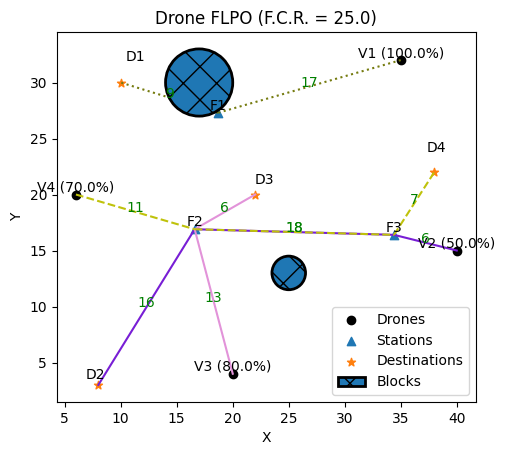

In [ ]:
env.print_routs()
env.plot_routs()

In [ ]:
np.round(env.Y_s[-1],3)

array([[ 9.01 ,  8.792,  0.49 ,  0.062],
       [ 0.494,  0.   ,  9.129,  9.34 ],
       [ 9.792,  9.233,  0.022,  0.   ],
       [17.088,  9.301,  1.096,  8.087]])